# Modeling Classification

In [15]:
#import libraires and read in data
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    GroupShuffleSplit,
    StratifiedGroupKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from google.colab import files
import io # Make sure to import io
# This returns a dictionary of uploaded files
uploaded = files.upload()

# Get the filename (assuming you uploaded only one file)
filename = list(uploaded.keys())[0]

# Read the file's content (bytes) into a pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Now this will work!
print(df.head())

!pip install codecarbon
from codecarbon import EmissionsTracker
import logging
import sys

# Start the total tracker
total_tracker = EmissionsTracker(
    measure_power_secs=1,
    save_to_file=False,
    log_level="error"
)
total_tracker.start()

Saving merged_health_census_clean.csv to merged_health_census_clean (2).csv
  StateAbbr    PlaceName  PlaceFIPS    TractFIPS        Place_TractID  \
0        CA  Los Angeles     644000   6037206032  0644000-06037206032   
1        CA     Pasadena     656000   6037462001  0656000-06037462001   
2        CA    Fullerton     628000   6059011504  0628000-06059011504   
3        TX     Longview    4843888  48183000401  4843888-48183000401   
4        WI      Madison    5548000  55025002200  5548000-55025002200   

   Tract_FIPS_full  Health_Pop  Obesity_Pct  Obesity_Count  Diabetes_Pct  ...  \
0       6037206032        5275         29.5         1556.0          15.5  ...   
1       6037462001        3974         32.0         1272.0          11.6  ...   
2       6059011504        5473         18.7         1023.0           4.6  ...   
3      48183000401        3371         33.9         1143.0           9.2  ...   
4      55025002200        4254         29.5         1255.0           8.7  ...   

In [16]:
df.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Tract_FIPS_full,Health_Pop,Obesity_Pct,Obesity_Count,Diabetes_Pct,...,Bachelors_Count,Unemployed_Pct,Unemployed_Count,Race_Total,Pct_White_Alone,Pct_Black_Alone,Pct_Asian_Alone,Majority_Race_Clean,Pct_Hispanic,Pct_Other
0,CA,Los Angeles,644000,6037206032,0644000-06037206032,6037206032,5275,29.5,1556.0,15.5,...,309,4.823990,185,5133,58.620690,0.935126,16.637444,Hispanic,77.089421,23.806741
1,CA,Pasadena,656000,6037462001,0656000-06037462001,6037462001,3974,32.0,1272.0,11.6,...,367,5.752670,167,3893,48.548677,10.608785,9.915232,Hispanic,70.459800,30.927305
2,CA,Fullerton,628000,6059011504,0628000-06059011504,6059011504,5473,18.7,1023.0,4.6,...,873,6.832522,379,6024,61.636786,1.626826,23.090969,White,30.378486,13.645418
3,TX,Longview,4843888,48183000401,4843888-48183000401,48183000401,3371,33.9,1143.0,9.2,...,201,4.592980,123,3170,82.965300,9.589905,3.470032,White,7.350158,3.974763
4,WI,Madison,5548000,55025002200,5548000-55025002200,55025002200,4254,29.5,1255.0,8.7,...,594,9.886264,339,4030,73.374690,11.116625,5.831266,White,8.263027,9.677419


In [17]:
df.shape

(27113, 50)

In [18]:
df.columns

Index(['StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS', 'Place_TractID',
       'Tract_FIPS_full', 'Health_Pop', 'Obesity_Pct', 'Obesity_Count',
       'Diabetes_Pct', 'Diabetes_Count', 'HighChol_Pct', 'HighChol_Count',
       'HighBP_Pct', 'HighBP_Count', 'Stroke_Pct', 'Stroke_Count', 'Sleep_Pct',
       'Sleep_Count', 'MentalHealth_Pct', 'MentalHealth_Count', 'Asthma_Pct',
       'Asthma_Count', 'HeartDisease_Pct', 'HeartDisease_Count', 'Smoking_Pct',
       'Smoking_Count', 'State_FIPS', 'County_FIPS', 'Tract_FIPS',
       'State_Name', 'County_Name', 'Tract_Name', 'Median_Income',
       'Median_Age', 'Poverty_Pct', 'Poverty_Count', 'HS_Grad_Pct',
       'HS_Grad_Count', 'Bachelors_Pct', 'Bachelors_Count', 'Unemployed_Pct',
       'Unemployed_Count', 'Race_Total', 'Pct_White_Alone', 'Pct_Black_Alone',
       'Pct_Asian_Alone', 'Majority_Race_Clean', 'Pct_Hispanic', 'Pct_Other'],
      dtype='object')

In [19]:
num_counties = df['County_FIPS'].nunique()
print("Number of unique counties:", num_counties)

Number of unique counties: 124


## Split Grouping and AUC

In [20]:
#create obesity categories
df["Obesity_Category"] = pd.qcut(df["Obesity_Pct"], q=3, labels=["Low", "Medium", "High"])

In [21]:
#get feature and target variables
feature_cols = [
    "Median_Income", "Median_Age", "Poverty_Pct",
    "HS_Grad_Pct", "Bachelors_Pct", "Unemployed_Pct",
    "Pct_White_Alone", "Pct_Black_Alone", "Pct_Asian_Alone",
    "Pct_Hispanic", "Pct_Other"
]
X = df[feature_cols]

y = df["Obesity_Category"]

In [22]:
#get just county FIPS
df['Tract_FIPS_full'] = df['Tract_FIPS_full'].astype(str).str.zfill(11)
df['County_FIPS'] = df['Tract_FIPS_full'].str[:5]
g = df["County_FIPS"]


In [23]:
#split and scale
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=80)
train_idx, test_idx = next(gss.split(X, y, groups=g))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
g_train = g.iloc[train_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
#convert y to numeric codes (0, 1, 2)
y_train_num = y_train.cat.codes if hasattr(y_train, "cat") else y_train
y_test_num = y_test.cat.codes if hasattr(y_test, "cat") else y_test

In [25]:
#binarize for multiclass ROC AUC
classes = y.cat.categories if hasattr(y, "cat") else np.unique(y)
y_test_bin = label_binarize(y_test_num, classes=np.arange(len(classes)))

#optimize KNN by ROC AUC
auc_scores = []
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_num)
    y_prob = knn.predict_proba(X_test_scaled)

    # Compute multiclass ROC AUC (one-vs-rest)
    auc = roc_auc_score(y_test_bin, y_prob, multi_class="ovr")
    auc_scores.append(auc)

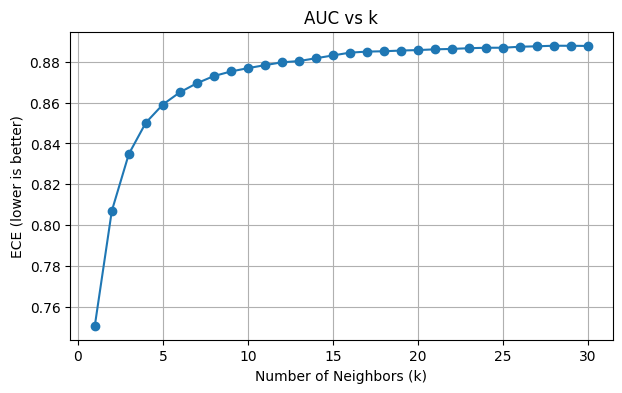

In [26]:
#plot AUC vs k
plt.figure(figsize=(7,4))
plt.plot(range(1, 31), auc_scores, marker="o")
plt.title("AUC vs k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("ECE (lower is better)")
plt.grid(True)
plt.show()

In [27]:
#test!

# Train final model using best_k
final_knn = KNeighborsClassifier(n_neighbors=10)
final_knn.fit(X_train_scaled, y_train_num)

# Predict on test set
y_pred = final_knn.predict(X_test_scaled)
y_prob = final_knn.predict_proba(X_test_scaled)

# Basic evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

acc = accuracy_score(y_test_num, y_pred)
ll = log_loss(y_test_num, y_prob)

print(f"Final KNN model (k={10}) evaluation:")
print(f"Accuracy: {acc:.4f}")
print(f"Log Loss: {ll:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_num, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_num, y_pred))


Final KNN model (k=10) evaluation:
Accuracy: 0.7231
Log Loss: 1.3756

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      2568
           1       0.62      0.57      0.59      2308
           2       0.75      0.78      0.76      1862

    accuracy                           0.72      6738
   macro avg       0.72      0.72      0.72      6738
weighted avg       0.72      0.72      0.72      6738


Confusion Matrix:
[[2107  426   35]
 [ 544 1311  453]
 [  17  391 1454]]


In [30]:

_ = total_tracker.stop()
total_data = total_tracker.final_emissions_data

print("\n=== Prediction (per 1,000,000 examples) ===")
print(f"Energy consumed: {total_data.energy_consumed:.6f} kWh")
print(f"CO2 emissions:  {total_data.emissions:.6f} kg CO2eq")


=== Prediction (per 1,000,000 examples) ===
Energy consumed: 0.000895 kWh
CO2 emissions:  0.000661 kg CO2eq
